## **Introduction**

This notebook analyzes a cohort of users who signed up for an Ultimate account in January 2014. The goal is to understand early user behavior and identify factors associated with long-term rider retention.

A user is considered **retained** if they were active (completed at least one trip) in the 30 days prior
to the data pull. This notebook focuses on data cleaning, exploratory data analysis (EDA), and feature
understanding in preparation for predictive modeling.


### Import Libararies

In [68]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Load Data from JSON

In [69]:
with open('/content/ultimate_data_challenge.json','r') as f:
  data = json.load(f)
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [71]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

### Date Parsing and Basic Cleaning

In [72]:
# Convert sign_up_date and last_trip_date to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [73]:
# Missing Value Assessment
df.isna().sum()

,0
city,0
trips_in_first_30_days,0
signup_date,0
avg_rating_of_driver,8122
avg_surge,0
last_trip_date,0
phone,396
surge_pct,0
ultimate_black_user,0
weekday_pct,0


### Handling Missing Values

Several features contain missing values, primarily in rating and device-related fields.
These missing values are not random and often reflect limited or no user activity.
Rather than dropping rows, we apply feature-specific imputation strategies to preserve information while avoiding bias and data leakage.  

**Note** - Including missing-indicator variables allows the model to learn whether the absence
of ratings itself is predictive of churn, which is often the case for low-engagement users.



In [74]:
# Missing Indicators
df['rating_of_driver_missing'] = df['avg_rating_of_driver'].isna().astype(int)
df['rating_by_driver_missing'] = df['avg_rating_by_driver'].isna().astype(int)



In [75]:
# Median Imputation
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())

# Fill missing phone category by 'unknown'
df['phone'] = df['phone'].fillna('unknown')

In [76]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,rating_of_driver_missing,rating_by_driver_missing
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,0,0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,0


In [77]:
df['rating_of_driver_missing'].value_counts(), df['rating_by_driver_missing'].value_counts()

(rating_of_driver_missing
 0    41878
 1     8122
 Name: count, dtype: int64,
 rating_by_driver_missing
 0    49799
 1      201
 Name: count, dtype: int64)

In [78]:
df.isna().sum()

,0
city,0
trips_in_first_30_days,0
signup_date,0
avg_rating_of_driver,0
avg_surge,0
last_trip_date,0
phone,0
surge_pct,0
ultimate_black_user,0
weekday_pct,0


### Define Retention Target Variable

A user is labeled as *retained* if they completed at least one trip in the 30 days
prior to the data pull. Since the exact pull date is not explicitly provided,
we infer it as the maximum observed `last_trip_date`.


In [79]:
cut_off_date = df['last_trip_date'].max()

df['retained'] = (df['last_trip_date'] >= (cut_off_date - pd.Timedelta(days=30))).astype(int)

df['retained'].value_counts(normalize=True)

,proportion
retained,
0,0.62392
1,0.37608


In [80]:
retention_rate = df['retained'].mean()
print(f'Overall retention rate: {retention_rate:.2%}')

Overall retention rate: 37.61%


### Retention Rate Summary

Approximately **37.6%** of users in the January 2014 cohort were retained, meaning they completed at least one trip in the 30 days prior to the data pull. The remaining **62.4%** of users churned before reaching their sixth month on the platform. This class imbalance highlights the importance of focusing on early engagement and pricing experience when modeling and improving long-term rider retention.


## **Exploratory Data Analysis**

### Early Engagement Analysis - Early Engagement vs Retention

Early usage is often the strongest predictor of retention. We examine the distribution of trips taken in the first 30 days and compare retained vs non-retained users.


In [81]:
df.groupby('retained')['trips_in_first_30_days'].describe()

,count,mean,std,min,25%,50%,75%,max
retained,,,,,,,,
0,31196.0,1.658482,2.654222,0.0,0.0,1.0,2.0,73.0
1,18804.0,3.306318,4.986743,0.0,0.0,2.0,4.0,125.0


<Axes: xlabel='retained'>

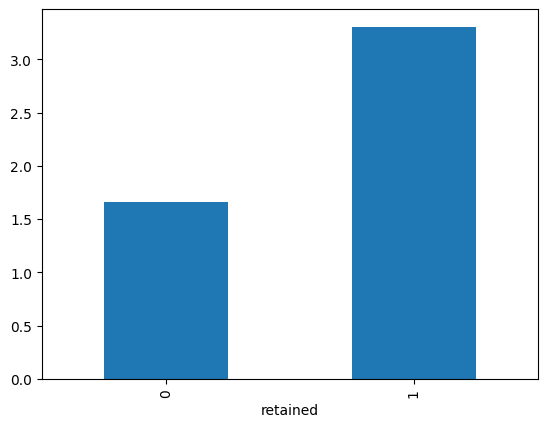

In [82]:
df.groupby('retained')['trips_in_first_30_days'].mean().plot(kind='bar')

Users who were retained exhibit substantially higher early engagement than those who churned.  
Retained users took an average of **3.3 trips** in their first 30 days, compared to **1.7 trips** for non-retained users. While both groups include users with zero initial trips, the median number of trips is higher for retained users (2 vs. 1), and the upper quartiles are consistently larger. This suggests that higher early activity is strongly associated with long-term retention, reinforcing early engagement as a key predictive signal.


### Weekday Usage Patterns

Weekday usage percentage may indicate habitual commuting behavior, which is often associated with stronger retention.


In [83]:
df.groupby('retained')['weekday_pct'].mean()

,weekday_pct
retained,
0,60.647032
1,61.389034


<Axes: xlabel='retained'>

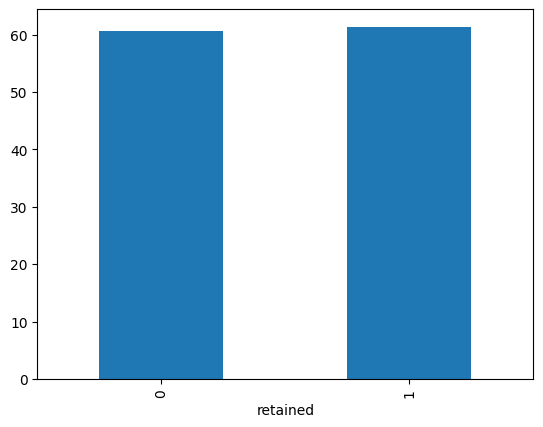

In [84]:
df.groupby('retained')['weekday_pct'].mean().plot(kind='bar')

Weekday usage patterns are similar between retained and churned users, with retained users exhibiting a slightly higher average weekday trip percentage (61.4% vs. 60.6%). While the difference is modest, this suggests that more regular weekday usage—often associated with routine or commuting behavior—may be weakly correlated with higher retention, though it is likely not a primary driver on its own.


### Surge Pricing Exposure

We analyze whether exposure to surge pricing early in the user lifecycle is associated with lower retention.


In [85]:
df.groupby('retained')[['surge_pct','avg_surge']].mean()

,surge_pct,avg_surge
retained,,
0,8.666739,1.075339
1,9.152797,1.073809


<Axes: xlabel='retained'>

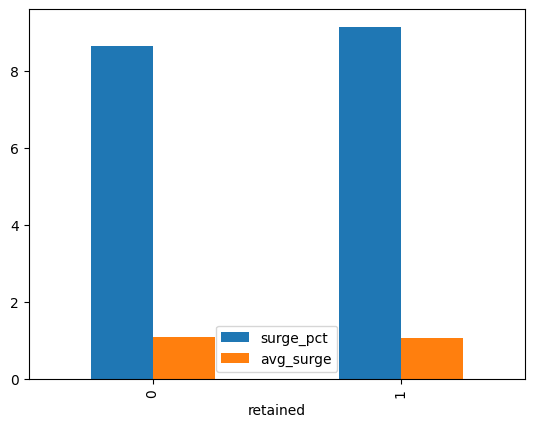

In [86]:
df.groupby('retained')[['surge_pct','avg_surge']].mean().plot(kind='bar')

Retained users experienced slightly higher exposure to surge pricing, with an average of 9.15% of trips under surge compared to 8.67% for churned users. However, the average surge multiplier is nearly identical across both groups (≈1.07). This suggests that moderate differences in surge exposure alone are unlikely to be a primary driver of retention, and that pricing effects may interact with other factors such as trip frequency or user value rather than acting independently.


### Ratings and User Experience

Ratings serve as proxies for user experience. We compare how drivers rated users and how users rated drivers across retention groups.


In [87]:
df.groupby('retained')[['avg_rating_by_driver','avg_rating_of_driver']].mean()

,avg_rating_by_driver,avg_rating_of_driver
retained,,
0,4.788588,4.668397
1,4.763226,4.619581


<Axes: xlabel='retained'>

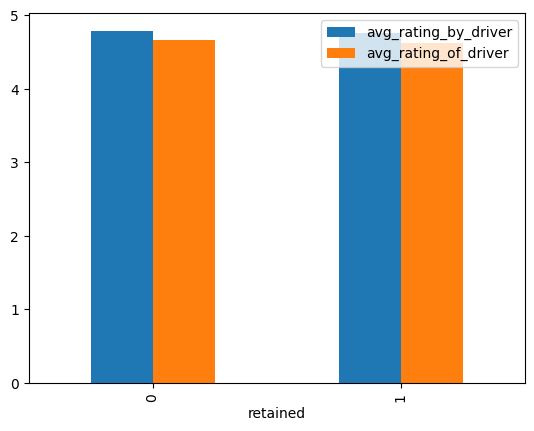

In [88]:
df.groupby('retained')[['avg_rating_by_driver','avg_rating_of_driver']].mean().plot(kind='bar')

### Ratings and Retention

Average ratings are high for both retained and churned users, with only minor differences between the two groups. Retained users are rated slightly lower by drivers (4.76 vs. 4.79) and also give marginally lower ratings to drivers (4.59 vs. 4.61). The narrow range and limited separation suggest that ratings may have limited standalone predictive power for retention and are more likely to act as secondary signals or interact with early engagement rather than being primary drivers of long-term retention.


### Categorical Feature Analysis - City, Phone, Product Usage

We examine retention differences across city, device type, and premium product usage (ultimate black user). These features capture structural and demographic variation in behavior.


In [89]:
# Retention by city
df.groupby('city')['retained'].value_counts(normalize=True).sort_index()

city            retained
Astapor         0           0.744285
                1           0.255715
King's Landing  0           0.371866
                1           0.628134
Winterfell      0           0.648055
                1           0.351945
Name: proportion, dtype: float64

<Axes: xlabel='city'>

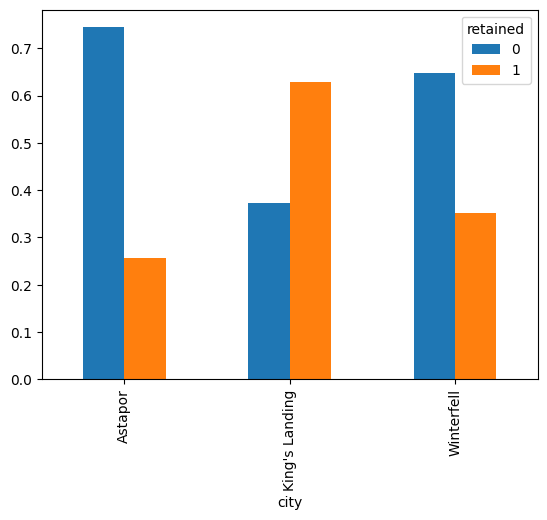

In [90]:
df.groupby('city')['retained'].value_counts(normalize=True).unstack().plot(kind='bar')

**Retention by City**

Retention rates vary substantially across cities. Users from **King’s Landing** show the highest retention, with approximately **62.8%** remaining active, suggesting stronger product-market fit or more consistent demand in that city. In contrast, **Astapor** exhibits the lowest retention, with only **25.6%** of users retained, indicating higher early churn. **Winterfell** falls in between, with a retention rate of **35.2%**. These differences suggest that city-level factors—such as demand patterns, pricing, or service quality—play an important role in long-term rider retention and should be considered when designing localized retention strategies.


In [91]:
# Retention by phone
df.groupby('phone')['retained'].value_counts(normalize=True)

phone    retained
Android  0           0.790574
         1           0.209426
iPhone   0           0.551067
         1           0.448933
unknown  0           0.664141
         1           0.335859
Name: proportion, dtype: float64

<Axes: xlabel='phone'>

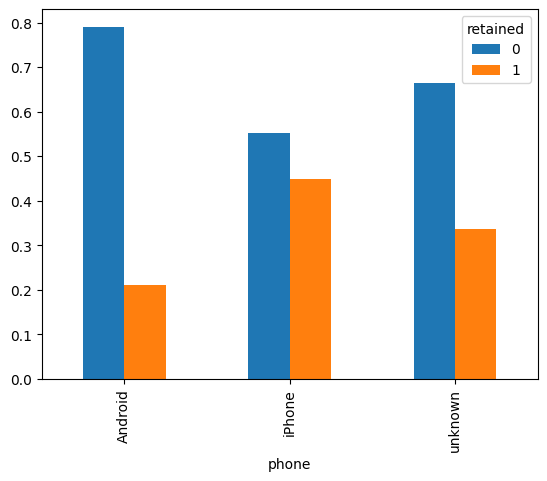

In [92]:
df.groupby('phone')['retained'].value_counts(normalize=True).unstack().plot(kind='bar')

**Retention by Phone Type**

Retention varies notably by device type. **iPhone users** show the highest retention, with approximately **44.9%** remaining active, compared to only **20.9%** of **Android users**. Users with an **unknown** device fall in between, with a retention rate of **33.6%**. These differences suggest that device type may proxy for underlying demographic or usage patterns, such as income level or travel frequency, and can be a meaningful predictor of long-term retention.


In [93]:
# Retention by premium product usage (ultimate black user )
df.groupby('ultimate_black_user')['retained'].value_counts(normalize=True)

ultimate_black_user  retained
False                0           0.701182
                     1           0.298818
True                 1           0.503713
                     0           0.496287
Name: proportion, dtype: float64

<Axes: xlabel='ultimate_black_user'>

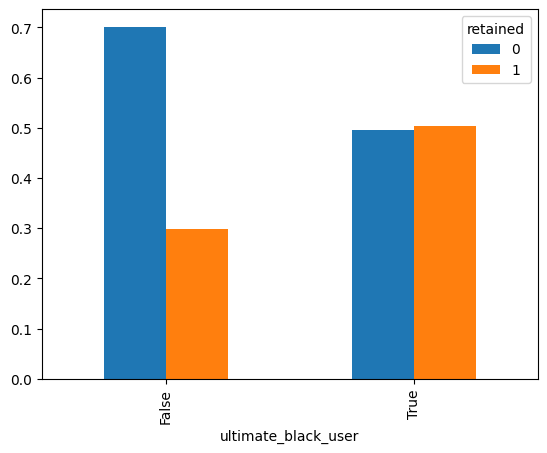

In [94]:
df.groupby('ultimate_black_user')['retained'].value_counts(normalize=True).unstack().plot(kind='bar')

**Premium Product Usage and Retention**

Users who adopted the **Ultimate Black** premium service show substantially higher retention than non-premium users. Approximately **50.4%** of Ultimate Black users were retained, compared to only **29.9%** of non-premium users. This strong separation suggests that early adoption of premium services is a meaningful indicator of long-term engagement, likely reflecting both higher usage intensity and greater willingness to pay.


### EDA Summary

Exploratory analysis shows that **early engagement is the strongest indicator of long-term retention**, with retained users taking significantly more trips in their first 30 days. Retention also varies meaningfully by **city**, **device type**, and **premium product usage**, suggesting structural and demographic influences on user behavior. Exposure to surge pricing and ratings exhibit relatively small differences between retained and churned users, indicating weaker standalone predictive power. Overall, the results highlight early usage intensity and product adoption as the most actionable signals for improving rider retention.


## **Predictive Modeling for Rider Retention**

### Modeling Objective
The objective is to predict whether a user will be retained, defined as having completed at least one trip in the 30 days prior to the data pull (i.e., active in their 6th month). This is a binary classification problem.  

### Modeling Approach
I chose logistic regression as the primary modeling approach. Logistic regression is well suited for this task because it:  
- Directly models a binary outcome
- Produces interpretable coefficients that quantify the relationship between user behavior and retention
- Performs reliably on tabular data with mixed numerical and categorical features
- Allows easy incorporation of missing-value indicators and regularization if needed


## Prepare Data for Modeling

We prepare the dataset for predictive modeling by separating features and the target variable. The target `retained` indicates whether a user was active in the 30 days prior to the data pull.
Features derived from future information are excluded to avoid data leakage.


In [95]:
# Target
y = df['retained']

# Drop leakage columns from features
X = df.drop(columns=['retained','last_trip_date'])

### Identify Numerical and Categorical Features

We separate numerical and categorical variables to apply appropriate preprocessing steps, such as scaling for numerical features and one-hot encoding for categorical features.


In [96]:
# Numeric featires
numeric_features = [
    "trips_in_first_30_days",
    "avg_dist",
    "weekday_pct",
    "surge_pct",
    "avg_surge",
    "avg_rating_of_driver",
    "avg_rating_by_driver",
    "rating_of_driver_missing",
    "rating_by_driver_missing"
]

# Categorical features
categorical_features = [
    "city",
    "phone",
    "ultimate_black_user"
]


### Train - Validation Split

We split the data into training and validation sets to evaluate model performance on unseen data. A stratified split preserves the class balance.


In [97]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [98]:
X_train.isna().sum()

,0
city,0
trips_in_first_30_days,0
signup_date,0
avg_rating_of_driver,0
avg_surge,0
phone,0
surge_pct,0
ultimate_black_user,0
weekday_pct,0
avg_dist,0


### Preprocessing Pipeline

Numerical features are `standardized` to improve model stability.
Categorical features are `one-hot encoded`.
A `ColumnTransformer` ensures consistent preprocessing across datasets.


In [99]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
)

### Train Logistic Regression Model

Logistic regression is used as the primary model due to its interpretability and effectiveness for binary classification on tabular data.


In [100]:
from scipy.sparse import random_array
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Model
model = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',LogisticRegression(
        max_iter = 1000,
        class_weight = 'balanced',
        random_state=42
    ))

])

# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['trips_in_first_30_days',
                                                   'avg_dist', 'weekday_pct',
                                                   'surge_pct', 'avg_surge',
                                                   'avg_rating_of_driver',
                                                   'avg_rating_by_driver',
                                                   'rating_of_driver_missing',
                                                   'rating_by_driver_missing']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['city', 'phone',
                                                   'ultimate_black_user'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

### Predictions

We generate both class predictions and predicted probabilities for evaluation.


In [101]:
# Prediction
y_pred = model.predict(X_val)

# Predicted probabilities
y_pred_prob = model.predict_proba(X_val)[:, 1]

### Model Evaluation Metrics

We evaluate the model using multiple metrics to account for class imbalance and provide a robust assessment of performance.


In [105]:
from sklearn.metrics import(
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# accuracy score
accuracy = accuracy_score(y_val, y_pred)
print('Accuracy :', accuracy)

# roc_auc
roc_auc = roc_auc_score(y_val, y_pred_prob)
print('ROC_AUC:',roc_auc )

# classification report
print('\nClassification Report:')
print(classification_report(y_val, y_pred))

# confusion matrix
print('\nConfusion Matrix:')
print(confusion_matrix(y_val, y_pred))

Accuracy : 0.69536
ROC_AUC: 0.761891172920216

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      7799
           1       0.58      0.69      0.63      4701

    accuracy                           0.70     12500
   macro avg       0.68      0.69      0.69     12500
weighted avg       0.71      0.70      0.70     12500


Confusion Matrix:
[[5443 2356]
 [1452 3249]]


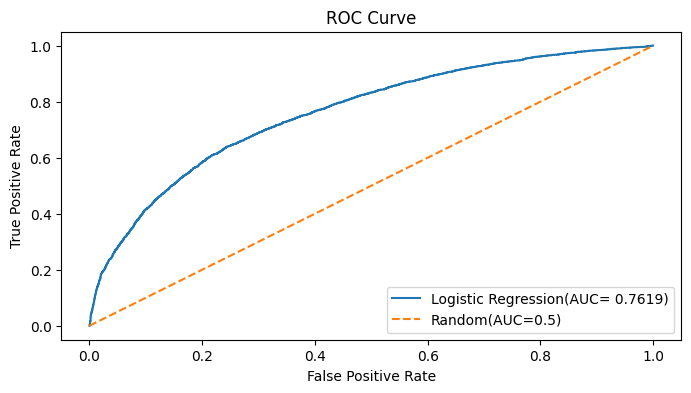

In [106]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_val, y_pred_prob)

# Plot
plt.figure(figsize=(8,4))
plt.plot(fpr,tpr, label=f"Logistic Regression(AUC= {roc_auc:.4f})")
plt.plot([0,1],[0,1], linestyle='--', label='Random(AUC=0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

### Model Performance

The logistic regression model achieves an accuracy of approximately 70% and a ROC-AUC of 0.76, indicating good discriminative ability between retained and churned users. The ROC-AUC score shows that the model is substantially better than random guessing and is effective at ranking users by their likelihood of retention, which is particularly valuable for targeted retention strategies.

The classification report indicates stronger performance in identifying churned users (class 0), with a precision of 0.79 and recall of 0.70. For retained users (class 1), the model achieves a recall of 0.69, meaning it successfully identifies the majority of users who remain active, although precision is lower at 0.58. This trade-off is expected in retention modeling, where capturing potential retained users often comes at the cost of some false positives.

The confusion matrix shows that out of 4,701 retained users, 3,249 are correctly classified, while 1,452 retained users are misclassified as churned. Additionally, 2,356 churned users are incorrectly predicted as retained, which reflects overlapping early-stage behavior between the two groups. Overall, the model provides a balanced and realistic performance profile, making it suitable for risk ranking and early intervention, rather than precise individual-level predictions.


### Hyperparameter Tuning Consideration

Extensive hyperparameter tuning was not performed, as the baseline logistic regression model already demonstrates stable and reasonable performance (ROC-AUC ≈ 0.76) using early-life behavioral features. Given the inherent noise in long-term retention prediction and the model's interpretability requirements, further gains are more likely to come from feature engineering or additional data rather than parameter optimization.


### Feature Importance

For logistic regression, coefficients indicate the direction and strength of each feature's relationship with retention.


In [107]:
feature_names = (
    model.named_steps["preprocessor"]
    .get_feature_names_out()
)

coefficients = model.named_steps["classifier"].coef_[0]

feature_importance = (
    pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefficients,
        "odds_ratio": np.exp(coefficients)
    })
    .sort_values(by="odds_ratio", ascending=False)
)

feature_importance.head(10)

,feature,coefficient,odds_ratio
10,cat__city_King's Landing,0.975821,2.653346
13,cat__phone_iPhone,0.554948,1.741850
16,cat__ultimate_black_user_True,0.412752,1.510971
0,num__trips_in_first_30_days,0.401807,1.494523
3,num__surge_pct,0.072825,1.075542
2,num__weekday_pct,-0.009237,0.990806
8,num__rating_by_driver_missing,-0.038720,0.962020
4,num__avg_surge,-0.042436,0.958452
5,num__avg_rating_of_driver,-0.042444,0.958444
14,cat__phone_unknown,-0.075053,0.927695


Retention is most strongly associated with early engagement, premium product usage, and structural user segments, while pricing and ratings play secondary roles.


## Model Insights to Improve Retention
Ultimate can use the model to spot new users who are likely to churn early and target them with timely actions such as ride credits, reminders, or promotions during their first month. Since early trip activity and premium service usage are strong signals of retention, the business should focus on encouraging frequent early use and offering premium trials. Differences by city and device type also suggest that retention efforts should be tailored locally rather than applied uniformly across all users.

## Model Validity and Limitations
The model is predictive rather than causal. While it identifies strong correlates of retention, it does not prove that these factors directly cause users to stay. Additionally, external influences such as promotions, competitive dynamics, or changes in pricing are not captured in the dataset and may affect real-world performance. Ratings also exhibit limited variance, which may reduce their individual impact.

## Alternatives Considered
Tree-based models such as Random Forests and Gradient Boosting were considered, while they can capture nonlinearities, their added complexity and reduced interpretability offer limited practical benefit for this dataset. Logistic regression was chosen for its interpretability and comparable performance on this dataset, also business explainabilty is a priority.